# Instalação

In [ ]:
!pip install xcompact3d_toolbox

# Escoamento ao longo de um corpo complexo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xcompact3d_toolbox as x3d

## Parâmetros

+ Precisão numérico

Se Xcompact3d foi compilada com a flag `-DDOUBLE_PREC` deve se usar `np.float64`, deve-se usar `np.float32` para os outros casos.

In [3]:
x3d.param["mytype"] = np.float64

* Xcompact3d's parâmetros

Para mais informações veja [API reference](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.parameters.Parameters).

In [5]:
prm = x3d.Parameters(
    filename="input.i3d",
    itype=12,
    p_row=0,
    p_col=0,
    nx=257,
    ny=129,
    nz=32,
    xlx=15.0,
    yly=10.0,
    zlz=3.0,
    nclx1=2,
    nclxn=2,
    ncly1=1,
    nclyn=1,
    nclz1=0,
    nclzn=0,
    iin=1,
    re=300.0,
    init_noise=0.0125,
    inflow_noise=0.0125,
    dt=0.0025,
    ifirst=1,
    ilast=45000,
    ilesmod=1,
    iibm=2,
    nu0nu=4.0,
    cnu=0.44,
    irestart=0,
    icheckpoint=45000,
    ioutput=200,
    iprocessing=50,
    jles=4,
)

## Configuração

### Geométria

Todo o que se precisa é um dicionário de Arrays (veja [API reference](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.sandbox.init_epsi)):

In [6]:
epsi = x3d.init_epsi(prm)

As quatro matrizes $\epsilon$ são salvas em um dicionário:

In [7]:
epsi.keys()

dict_keys(['epsi', 'xepsi', 'yepsi', 'zepsi'])

Como exemplo, será desenhado e graficado um cilindro. Para fazer um gráfico `xarray.DataArray` é mais simples com `da.plot()`. Por exemplo, para selecionar um valor em $z$ e fazer um gráfico 2D:

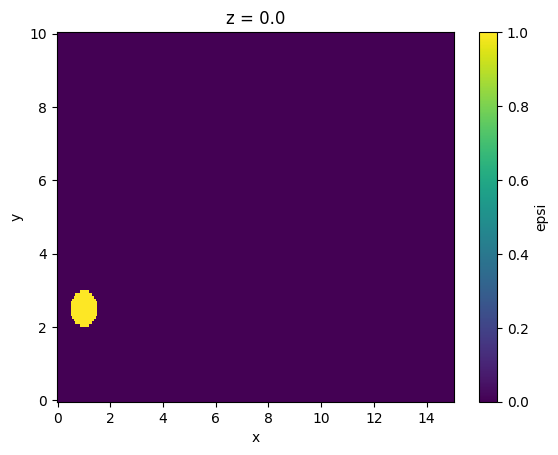

In [8]:
for key in epsi:
    epsi[key] = epsi[key].geo.cylinder(x=1, y=prm.yly / 4.0)

epsi["epsi"].sel(z=0, method="nearest").plot(x="x");

Nota-se que as geométrias são adicionadas por padrão, todavia, ela pode ser revertida definindo `remp=False`. Vários métodos podem ser executados em cadeia, resultando em uma geométria mais complexa.

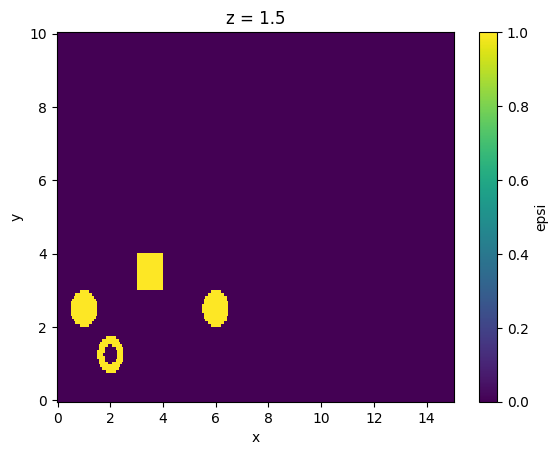

In [9]:
for key in epsi:
    epsi[key] = (
        epsi[key]
        .geo.cylinder(x=2, y=prm.yly / 8.0)
        .geo.cylinder(x=2, y=prm.yly / 8.0, radius=0.25, remp=False)
        .geo.sphere(x=6, y=prm.yly / 4, z=prm.zlz / 2.0)
        .geo.box(x=[3, 4], y=[3, 4])
    )

epsi["epsi"].sel(z=prm.zlz / 2, method="nearest").plot(x="x");

Outro exemplo é o corpo de Ahmed:

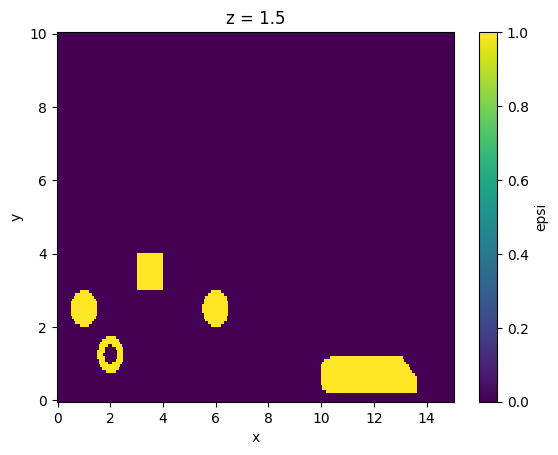

In [10]:
for key in epsi:
    epsi[key] = epsi[key].geo.ahmed_body(x=10, wheels=False)

epsi["epsi"].sel(z=prm.zlz / 2, method="nearest").plot(x="x");

DAndo um zoom:

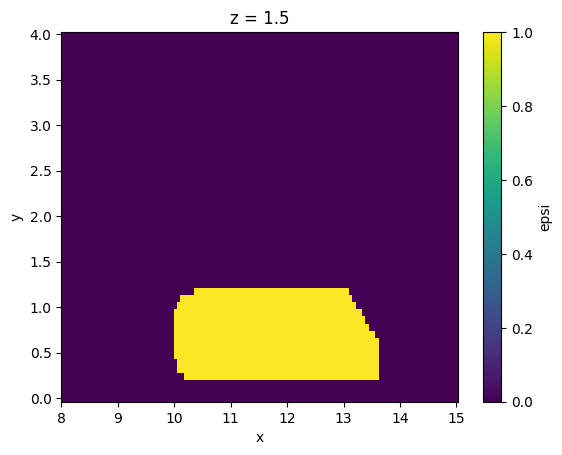

In [11]:
epsi["epsi"].sel(x=slice(8, None), y=slice(None, 4)).sel(z=prm.zlz / 2, method="nearest").plot(x="x");

Como exemplo, pode-se espelha-lo:

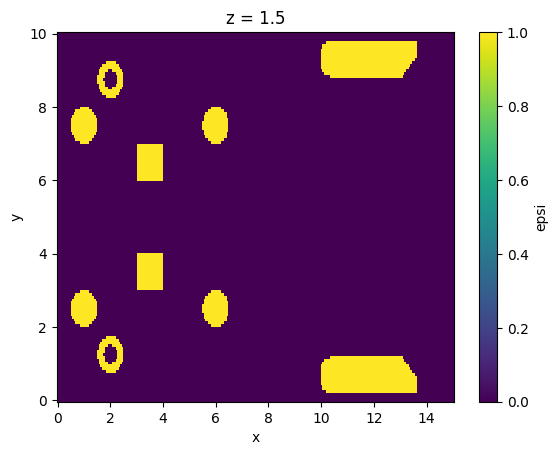

In [12]:
for key in epsi:
    epsi[key] = epsi[key].geo.mirror("y")

epsi["epsi"].sel(z=prm.zlz / 2, method="nearest").plot(x="x");

Isso demonstra a capacidade do `xcompact3d_toolbox.sandbox` em construir diferentes geométrias. No entanto, não esqueça a estabilidade numérica do solver numérico do Xcompact3d **é responsabilidade do usuário achar o conjunto certo de parâmetros físicos e numéricos**.

Para uma descrição completa das geométrias avaliadas veja a [referência da Api](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.sandbox.Geometry). Observe que se pode combinar diferentes rotinas para criar geométrias únicas, ou criar rotinas únicas para seus objetos.

Começando com uma geométria simples:

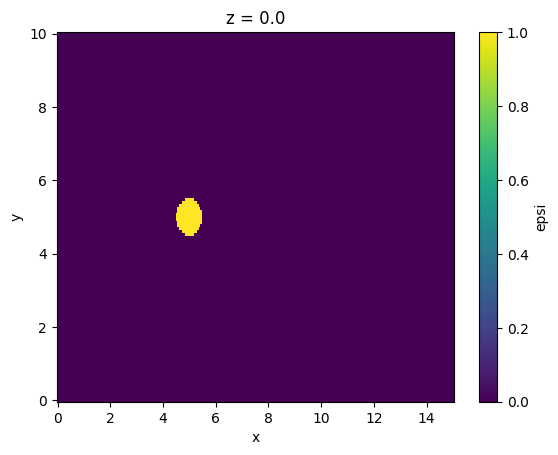

In [13]:
epsi = x3d.sandbox.init_epsi(prm)

for key in epsi:
    epsi[key] = epsi[key].geo.cylinder(x=prm.xlx / 3, y=prm.yly / 2)

epsi["epsi"].sel(z=0, method="nearest").plot(x="x")
plt.show();

O próximo passo é criar os arquivos auxiliares descrevendo as geométrias, para que o Xcompact3d possa lê-lo.

In [14]:
%%time
dataset = x3d.gene_epsi_3d(epsi, prm)

prm.nobjmax = dataset.obj.size

dataset

CPU times: user 5.27 s, sys: 239 ms, total: 5.51 s
Wall time: 5.71 s


<xarray.Dataset> Size: 4MB
Dimensions:       (x: 257, y: 129, z: 32, obj: 1, obj_aux: 2)
Coordinates:
  * x             (x) float64 2kB 0.0 0.05859 0.1172 0.1758 ... 14.88 14.94 15.0
  * y             (y) float64 1kB 0.0 0.07812 0.1562 0.2344 ... 9.844 9.922 10.0
  * z             (z) float64 256B 0.0 0.09375 0.1875 ... 2.719 2.812 2.906
  * obj           (obj) int64 8B 0
  * obj_aux       (obj_aux) int64 16B -1 0
Data variables: (12/28)
    epsi          (x, y, z) bool 1MB False False False ... False False False
    nobj_x        (y, z) int64 33kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nobjmax_x     int64 8B 1
    nobjraf_x     (y, z) int64 33kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nobjmaxraf_x  int64 8B 1
    ibug_x        int64 8B 0
    ...            ...
    nxipif_y      (x, z, obj_aux) int64 132kB 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2
    nxfpif_y      (x, z, obj_aux) int64 132kB 128 2 128 2 128 ... 2 128 2 128 2
    xi_z          (x, y, obj) float64 265kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    xf_z          (x, y, obj) float64 265kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nxipif_z      (x, y, obj_aux) int64 530kB 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2
    nxfpif_z      (x, y, obj_aux) int64 530kB 31 2 31 2 31 2 ... 31 2 31 2 31 2

### Condição de contorno

Tudo que se precisa é de um Dataset (veja a [referência da API](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.sandbox.init_dataset)):

In [15]:
ds = x3d.init_dataset(prm)

Com dados e atributos anexados, pode-se interagir com os icons:

In [16]:
ds

<xarray.Dataset> Size: 26MB
Dimensions:       (x: 257, y: 129, z: 32, n: 0)
Coordinates:
  * x             (x) float64 2kB 0.0 0.05859 0.1172 0.1758 ... 14.88 14.94 15.0
  * y             (y) float64 1kB 0.0 0.07812 0.1562 0.2344 ... 9.844 9.922 10.0
  * z             (z) float64 256B 0.0 0.09375 0.1875 ... 2.719 2.812 2.906
  * n             (n) float64 0B 
Data variables:
    bxx1          (y, z) float64 33kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bxy1          (y, z) float64 33kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bxz1          (y, z) float64 33kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    noise_mod_x1  (y, z) float64 33kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ux            (x, y, z) float64 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    uy            (x, y, z) float64 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    uz            (x, y, z) float64 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

**Perfil de entrada**: Como as condições de contorno para a velocidade no topo e no fundo do domínio são de deslizamento-livre, nesse caso (`ncly1=nclyn=1`), o perfil de entrada é fluxo contínuo.

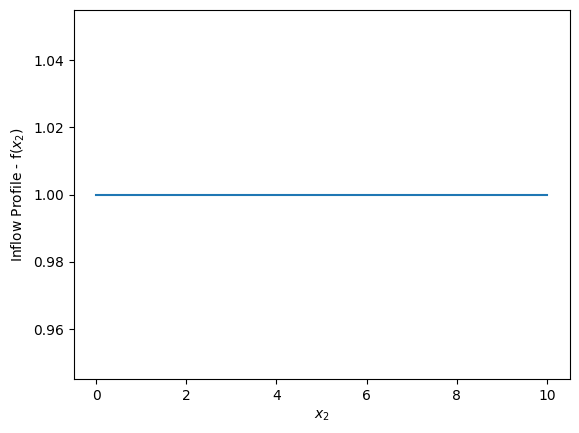

In [17]:
fun = xr.ones_like(ds.y)

# This attribute will be shown in the figure
fun.attrs["long_name"] = r"Inflow Profile - f($x_2$)"

fun.plot();

Reiniciando o plano de entrada `ds[key] *= 0.0`, só para guarantir consistência em multiplas execuções dessa célula. Observe que `ds[key] = 0.0` pode reescrever todos os metadados contidos no array, por isso devi-se evita-lo. Na célula a baixo se adicionou-se o perfil de entrada e fazer o gráfico dele como referência:

Inflow Plane for Streamwise Velocity


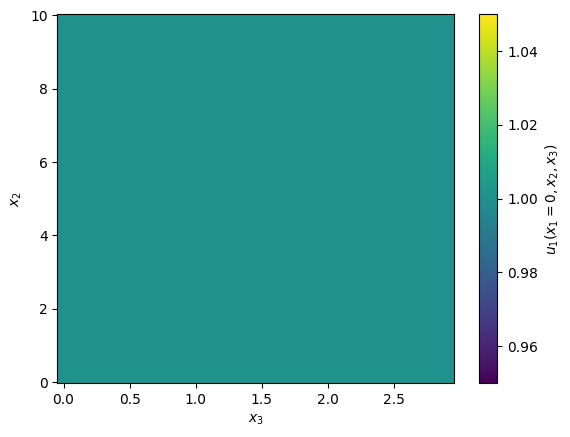

Inflow Plane for Vertical Velocity


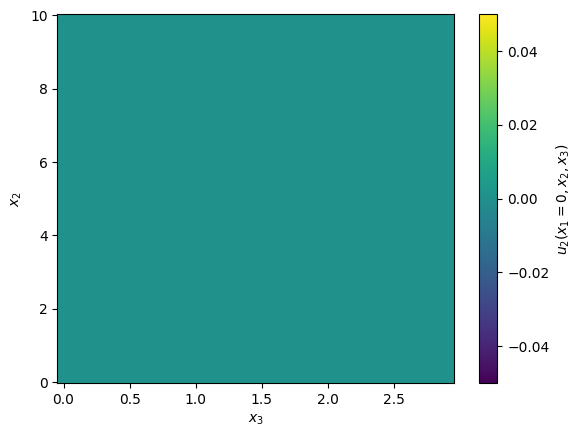

Inflow Plane for Spanwise Velocity


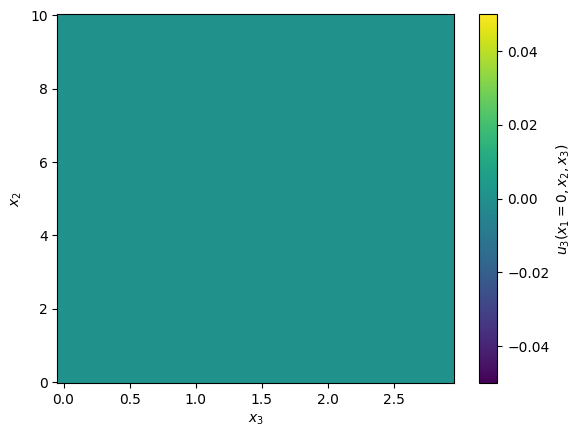

In [18]:
for key in "bxx1 bxy1 bxz1".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    #
    if key == "bxx1":
        ds[key] += fun
    #
    ds[key].plot()
    plt.show()

plt.close("all")

A random noise will be applied at the inflow boundary, we can create a modulation function `mod` to control were it will be applied. In this case, we will concentrate the noise near the center region and make it zero were $y=0$ and $y=L_y$. The domain is periodic in $z$ `nclz1=nclzn=0`, so there is no need to make `mod` functions of $z$. The functions looks like:

$$
\text{mod} = \exp\left(-0.2 (y - 0.5 L_y)^2 \right).
$$

See the code:

In [ ]:
# Random noise with fixed seed,
# important for reproducibility, development and debugging
if prm.iin == 2:
    np.random.seed(seed=67)

mod = np.exp(-0.2 * (ds.y - ds.y[-1] * 0.5) ** 2.0)

# This attribute will be shown in the figure
mod.attrs["long_name"] = "Noise modulation"

mod.plot();

Again, we reset the array `ds['noise_mod_x1'] *= 0.0`, just to guarantee consistency in case of multiple executions of this cell. Notice that `ds['noise_mod_x1'] *= 0.0` may overwrite all the metadata contained in the array, so it should be avoided. Then, we add the modulation profile to the proper array and plot it for reference:

In [ ]:
ds["noise_mod_x1"] *= 0.0
ds["noise_mod_x1"] += mod
ds.noise_mod_x1.plot();

Notice one of the many advantages of using [xarray](http://docs.xarray.dev/en/stable), `mod`, with shape (`ny`), was automatically broadcasted for every point in `z` into `ds.noise_mod_x1`, with shape (`ny`, `nz`).

### Initial Condition

Now we reset velocity fields `ds[key] *= 0.0`, just to guarantee consistency in the case of multiple executions of this cell.

We then add a random number array with the right shape, multiply by the noise amplitude at the initial condition `init_noise` and multiply again by our modulation function `mod`, defined previously. Finally, we add the streamwise profile `fun` to `ux` and make the plots for reference, I'm adding extra options just to exemplify how easily we can slice the spanwise coordinate and produce multiple plots:

In [ ]:
for key in "ux uy uz".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    ds[key] += prm.init_noise * (np.random.random(ds[key].shape) - 0.5)
    ds[key] *= mod
    #
    if key == "ux":
        ds[key] += fun
    #
    ds[key].sel(z=slice(None, None, ds.z.size // 3)).plot(x="x", y="y", col="z", col_wrap=2)
    plt.show()
    #

plt.close("all")

## Writing to disc

is as simple as:

In [ ]:
prm.dataset.write(ds)

In [ ]:
prm.write()

## Running the Simulation

It was just to show the capabilities of `xcompact3d_toolbox.sandbox`, keep in mind the aspects of numerical stability of our Navier-Stokes solver. **It is up to the user to find the right set of numerical and physical parameters**.

Make sure that the compiling flags and options at `Makefile` are what you expect. Then, compile the main code at the root folder with `make`.

And finally, we are good to go:

```bash
mpirun -n [number of cores] ./xcompact3d |tee log.out
```